# Graph Neural Network

### Table of Contents:
* [0: Introducing the Model](#0-introducing-the-model)
* [1: Importing Modules and Reading Data](#1-importing-modules-and-reading-data)
* [2: Deciding the Question](#2-deciding-the-question)
* [3: Creating the Train-Test Split](#3-creating-the-train-test-split)
* [4: Exploring the Model](#4-exploring-the-model)
* [5: Testing the Model](#5-testing-the-model)
* [6: Tuning the Model](#6-tuning-the-model)
* [7: Running the Final Model](#7-running-the-final-model)
* [8: Getting Recommendations](#8-getting-recommendations)
* [9: Investigating the Computational Performance of the Model](#9-investigating-the-computational-performance-of-the-model)
* [10: Conclusion](#10-conclusion)
* [11: References](#11-references)

## 0: Introducing the Model

We have already laid out the basic idea of Graph Neural Networks (GNNs) in the introduction, and as such we will instead introduce a useful variant, known as Graph Convolutional Networks (GCNs). GCNs are the most prevelant and broadly applied model of GNNs, [1] which are able to leverage both the information of the nodes and their locality to make predictions [2]. They do this using a convolution layer, which merges the features of a node with those of its neighbours. The most common method of recommender systems used with GCNs is Collaborative Filtering, where user's past interactions and connections to other users is used to make predictions. The main way it does this is through learning latent features (or an embedding) for each user and item node. GCNs then update this embedding by propagating information across the graph:

Let $\mathbf{e}_u^{(0)}$ denote the user embedding of user $u$, and $\mathbf{e}_i^{(0)}$ the item embedding of item $i$. Then after $k$ layers of propagation, we have:

$$\mathbf{e}_u^{(k+1)} = \sigma \left( \mathbf{W}_1 \mathbf{e}_u^{(k)} + \sum_{i\in \mathcal{N}_u} \frac{1}{\sqrt{|\mathcal{N}_u||\mathcal{N}_i|}} (\mathbf{W}_1\mathbf{e}_u^{(k)} + \mathbf{W}_2(\mathbf{e}_i^{(k)}\odot \mathbf{e}_u^{(k)}))\right)$$

and a similar equation for $\mathbf{e}_i^{(k+1)}$ [3]. In this equation, $\sigma$ is the nonlinear activation function (e.g. ReLU), $\mathcal{N}_u$ denotes the set of items that are interacted with by user $u$, and similar for $\mathcal{N}_i$ and item $i$. $\mathbf{W}_1$ and $\mathbf{W}_2$ are trainable weight matrices used to perform feature transformations in each layer.

These equations represent the basic building block of most GCNs, however after recent investigations as published in paper [3], it was discovered that for recommendation systems in particular, both the activation function, $\sigma$, and the feature transformation matrices, $\mathbf{W}_1, \mathbf{W}_2$, have little influence on the model and in fact make the predictions worse in some situations. As such a new model was suggested that stripped these parts for a much simpler propogation method:

$$\mathbf{e}_u^{(k+1)} = \sum_{i\in \mathcal{N}_u} \frac{1}{\sqrt{|\mathcal{N}_u||\mathcal{N}_i|}} \mathbf{e}_i^{(k)}$$

$$\mathbf{e}_i^{(k+1)} = \sum_{u\in \mathcal{N}_i} \frac{1}{\sqrt{|\mathcal{N}_i||\mathcal{N}_u|}} \mathbf{e}_u^{(k)}$$

This model is known as LightGCN, and was shown to perform better in most cases than the other prevalent GCN and GNN models for recommendation systems. This goes to show that more complicated is not always better, which carries over to data at scale. Sometimes one of the best ways to deal with big data is to make sure your model isn't performing unnecessary calculations.

LightGCN is still among the best models for collaborative filtering in recommender systems, and as such is the one that we will consider here.

---

## 1: Importing Modules and Reading Data

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import sys
import torch
import requests
import io
import contextlib
from sklearn.model_selection import train_test_split
from IPython import get_ipython

sys.path.append(os.path.join('..','scripts'))

import GraphFuncs as gf

In [2]:
artists = pd.read_csv(os.path.join('..','data','artists.dat'), delimiter='\t')
tags = pd.read_csv(os.path.join('..','data','tags.dat'), delimiter='\t',encoding='ISO-8859-1')
user_artists = pd.read_csv(os.path.join('..','data','user_artists.dat'), delimiter='\t')
user_friends = pd.read_csv(os.path.join('..','data','user_friends.dat'), delimiter='\t')
user_taggedartists_timestamps = pd.read_csv(os.path.join('..','data','user_taggedartists-timestamps.dat'), delimiter='\t')
user_taggedartists = pd.read_csv(os.path.join('..','data','user_taggedartists.dat'), delimiter='\t')

---

## 2: Deciding the Question

The goal of a recommender system is to try to predict which items a user will like, and then give them recommendations based on this. In this section, for our dataset, we will look at the goal of predicting whether or not a user will like an artist. To achieve this, we will create an 80-20 training-testing split of the data. We have seen that for most users, the `user_artist` dataset contains their top 50 artists, so we will take 40 of them for each user at random, and isolate the other 10 to use as testing data. We will then train a GNN on the 40 artists in the training dataset, and evaluate the model by seeing how it predicts if the user will like the 10 artists in the testing data. If the model performs well on this target, then we could use the model to predict whether or not a user will like an artist not contained in their 50 artists.

---

## 3: Creating the Train-Test Split

In order to create the train-test split we will use the Scikit-learn module, which has a built in function for it. It also has a built in `stratify` parameter, which allows us to specify that the data should be split whilst keeping the proportion of data the same for each user, i.e. what we described above. However this requires that each user has atleast 2 artist data entries, but we see that this is not the case:

In [3]:
users = user_artists['userID'].unique()
singleartistusers = [int(user) for user in users if len(gf.get_artists(user,user_artists)) == 1]
print(singleartistusers)

[112, 615, 1013, 1307, 1603, 1731, 1758, 2085]


We see that there are 8 users with only 1 artist data entry. As such we remove those, create the train-test split, and then re-add those users back to the training data:

In [4]:
# Isolate the rows of data for the users which only have one artist data point.
singleartistusersdf = user_artists[user_artists['userID'].isin(singleartistusers)]
# Take the rest of the data into a temp df
user_artists_temp = user_artists[~user_artists['userID'].isin(singleartistusers)]

# Create the train-test split using this temp df
user_artists_train, user_artists_test = train_test_split(user_artists_temp,
                                                          test_size = 0.2, 
                                                          stratify = user_artists_temp['userID'], 
                                                          random_state = 47)

# Concat the dfs back together
user_artists_train = pd.concat([user_artists_train,singleartistusersdf])

Then we save the datasets as text files so that the model can access them.

In [5]:
dfs = [user_artists_train, user_artists_test, user_friends]

filepath = os.path.join('..','data','GNN')
if not os.path.exists(filepath):
    os.makedirs(filepath)

for df in dfs:
    df.to_csv(os.path.join(filepath,gf.get_df_name(df, globals()) + '.txt'),sep='\t',header=False,index=False)

---

## 4: Exploring the Model

In order to use the LightGCN model, we have downloaded the scripts from the GitHub repository [4] associated with the paper [3] that suggested the model. This repository already had a Last.fm dataset built in, however it is different to ours and as such we must alter the code to run to our needs. This mostly involved adding a new class in the `dataloader.py` script, known as LastFM2, which was done by altering the already existing LastFM class.

In [6]:
with open(os.path.join('..','scripts','LightGCN','dataloader.py')) as file:
    content = file.read()
    start = content.index('class LastFM2')
    print(content[start:start+1000] + ' \nOutput Truncated.')

class LastFM2(BasicDataset):
    """
    Dataset type for pytorch
    LastFM dataset 2
    """
    def __init__(self, path=os.path.join('..','data','GNN')):
        # train or test
        cprint("loading [last fm 2]")
        self.mode_dict = {'train':0, "test":1}
        self.mode    = self.mode_dict['train']
        # self.n_users = 2100
        # self.m_items = 18745
        trainData = pd.read_table(join(path, 'user_artists_train.txt'), header=None)
        #print(trainData.head())
        testData  = pd.read_table(join(path, 'user_artists_test.txt'), header=None)
        #print(testData.head())
        trustNet  = pd.read_table(join(path, 'user_friends.txt'), header=None).to_numpy()
        #print(trustNet[:5])
        trustNet -= 1
        trainData-= 1
        testData -= 1
        self.trustNet  = trustNet
        self.trainData = trainData
        self.testData  = testData
        self.trainUser = np.array(trainData[:][0])
        self.trainUniqueUsers = np.unique(self.trainU

We have also made other alterations to the code to suit our needs for the model. These changes will be annotated in the scripts themselves with comments starting with 'SH8', and mentioned in this document where appropriate.

The downloaded scripts are contained in the `../scripts/LightGCN` directory.

We have also made other alterations to the code to suit our needs for the model. These changes will be annotated in the scripts themself where appropriate.

---

## 5: Testing the Model

To run the model, we use the `%run` magic command to access and run the script. Here we will run a small test of 10 epochs just to check that the model is working correctly. An epoch is a single run of the data through the algorithm. The more epochs we run, the better trained the model will be.

In [7]:
%run -i ../scripts/LightGCN/main.py --decay=1e-4 --lr=0.001 --layer=3 --seed=3 --dataset="lastfm2" --topks="[20]" --recdim=64 --epochs=10 --device=CPU

Verbose = True
Device used is cpu.
Cpp extension not loaded
>>SEED: 3
loading [last fm 2]
LastFm2 Sparsity : 0.00235706955576828
===========config================
{'A_n_fold': 100,
 'A_split': False,
 'bigdata': False,
 'bpr_batch_size': 2048,
 'decay': 0.0001,
 'dropout': 0,
 'keep_prob': 0.6,
 'latent_dim_rec': 64,
 'lightGCN_n_layers': 3,
 'lr': 0.001,
 'multicore': 0,
 'pretrain': 0,
 'test_u_batch_size': 100}
cores for test: 8
comment: lgn
tensorboard: 1
LOAD: 0
Weight path: ./checkpoints
Test Topks: [20]
using bpr loss
===========end===================
Device used is cpu.
Cpp extension not loaded
loading [last fm 2]
LastFm2 Sparsity : 0.00235706955576828
===========config================
{'A_n_fold': 100,
 'A_split': False,
 'bigdata': False,
 'bpr_batch_size': 2048,
 'decay': 0.0001,
 'dropout': 0,
 'keep_prob': 0.6,
 'latent_dim_rec': 64,
 'lightGCN_n_layers': 3,
 'lr': 0.001,
 'multicore': 0,
 'pretrain': 0,
 'test_u_batch_size': 100}
cores for test: 8
comment: lgn
tensorboard

C:\Users\Sheri\Documents\GitHub\dst-assessment-2\scripts\LightGCN\dataloader.py:490: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\torch\csrc\utils\tensor_new.cpp:653.)
  self.Graph = torch.sparse.IntTensor(index, data, torch.Size([self.n_users+self.m_items, self.n_users+self.m_items]))


lgn is already to go(dropout:0)
load and save to C:\Users\Sheri\Documents\GitHub\dst-assessment-2\scripts\code\checkpoints\lgn-lastfm2-3-64-3.pth.tar
[TEST]
{'precision': array([0.00055792]), 'recall': array([0.00112174]), 'ndcg': array([0.00072005])}
EPOCH[10/10] loss0.205-|Sample:0.69|[TEST]
{'precision': array([0.06657811]), 'recall': array([0.13601918]), 'ndcg': array([0.13879479])}
Total time taken: 85.10709691047668
Training time: 74.0718719959259


We see that even just for 10 epochs, the model takes a very long time to train (around 75 seconds in our tests). This is because we are running it on the device's CPU. When it comes to machine learning, and especially for big datasets, running the model on the CPU is usually very slow and not ideal. Instead a GPU is often used since GPUs are designed to perform many parallel operations, which is very useful for training neural network models on large datasets. PyTorch and other frameworks for neural networks have this feature built in, and with the help of the CUDA platform we can efficiently use a GPU to run the models if one is available. CUDA is a platform published by NVIDIA which allows for general-purpose processing on their GPUs [5,6]. This section will use CUDA 12.4 to run the model on a NVIDIA RTX 3060 Ti GPU:

In [8]:
%run -i ../scripts/LightGCN/main.py --decay=1e-4 --lr=0.001 --layer=3 --seed=3 --dataset="lastfm2" --topks="[20]" --recdim=64 --epochs=10 --device=GPU

Verbose = True
>>SEED: 3
Device used is cuda.
Cpp extension not loaded
loading [last fm 2]
LastFm2 Sparsity : 0.00235706955576828
===========config================
{'A_n_fold': 100,
 'A_split': False,
 'bigdata': False,
 'bpr_batch_size': 2048,
 'decay': 0.0001,
 'dropout': 0,
 'keep_prob': 0.6,
 'latent_dim_rec': 64,
 'lightGCN_n_layers': 3,
 'lr': 0.001,
 'multicore': 0,
 'pretrain': 0,
 'test_u_batch_size': 100}
cores for test: 8
comment: lgn
tensorboard: 1
LOAD: 0
Weight path: ./checkpoints
Test Topks: [20]
using bpr loss
===========end===================
use NORMAL distribution initilizer
lgn is already to go(dropout:0)
load and save to C:\Users\Sheri\Documents\GitHub\dst-assessment-2\scripts\code\checkpoints\lgn-lastfm2-3-64-3.pth.tar
[TEST]
{'precision': array([0.00055792]), 'recall': array([0.00112174]), 'ndcg': array([0.00072005])}
EPOCH[10/10] loss0.205-|Sample:0.83|[TEST]
{'precision': array([0.06657811]), 'recall': array([0.13601918]), 'ndcg': array([0.13879468])}
Total tim

In our tests, we have seen that on a GPU, the time taken has gone from around 75 seconds to just 20 seconds (and training time reduced from around 65 to around 12). A significant time improvement, especially if we want to run the models for more epochs, which we often will. For this model, we often want to run the model for hundreds or possibly even a thousand epochs.

In [9]:
os.remove(os.path.join('..','scripts','LightGCN','results','results_l3_rd64_lr0.001_3.csv'))

---

## 6: Tuning the Model

LightGCN has a few parameters that we may want to tune. This includes but is not limited to:

* The number of layers: `--layer`. In a GCN the number of layers represents how far we want information to propagate across the graph. 1 layer means that a node will only receive information from its direct neighbours, whilst 2 layers would provide information from a node's neighbour's neighbours as well, and so on.
* The embedding size of the nodes: `--recdim`. This represents the number of features each node embedding has, essentially dictating the capacity of information that each node can hold.
* The learning rate: `--lr`, i.e. how much the model is adjusted with respect to the loss function during training. A high learning rate might make the model converge quickly to a solution, but this solution may not be optimal. A lower learning rate means the model might take a long time or get stuck in a local minima.

To better investigate tuning these parameters, we write a function to allow us to easily run the model whilst changing parameters, e.g. in a for loop. We do this by using the IPython module, which lets you run line magic from a string, which we can thus format:

In [10]:
def LightGCN(decay = 1e-4, lr = 0.001, layer = 3, seed = 47, dataset = "lastfm2", 
             topks = 20, recdim = 64, epochs = 100, device = 'GPU', verbose = True):
    # Create results.csv to store the performance metrics
    resultspath = os.path.join('..','scripts','LightGCN','results')
    if not os.path.exists(resultspath):
        os.makedirs(resultspath)
    filename = f'results_l{layer}_rd{recdim}_lr{lr}_{seed}.csv'
    resultsfile = os.path.join(resultspath,filename)
    if os.path.exists(resultsfile):
        os.remove(resultsfile)
    pd.DataFrame(columns=['precision','recall','ndcg']).to_csv(resultsfile)
    # Run the model
    get_ipython().run_line_magic('run', f'-i ../scripts/LightGCN/main.py --decay={decay}'
                                  + f' --lr={lr} --layer={layer} --seed={seed} --dataset={dataset}'
                                  + f' --topks="[{topks}]" --recdim={recdim} --epochs={epochs}'
                                  + f' --device={device} --verbose={verbose}')

Since our goal is to train a model that works well to generate new predictions, we will use the testing data as validation data to evaluate the performance of the model, and then use the model to predict if a user will like artists that we do not have data on them liking.

The model will be evaluated every 10 epochs on three metrics:

* precision at k: This represents how many out of the top k predictions are present in the testing dataset.
* recall at k: This represents how many of the items in the testing dataset are present in the top k predictions.
* ndcg at k: NDCG stands for Normalized Discounted Cumulative Gain, and is a metric that compares predicted rankings of recommendations to an ideal order where all the testing datapoints are at the top of the list.

These may also be written as `precision@k`, `recall@k`, and `ndcg@k`, where this k is the same as the `--topks` parameter of the model.

The code below is commented out since it takes a very long time to run, but we have left it in to show what we did. We performed a manual gridsearch for the parameters, trying 36 different combinations to find which is best. We then plot the results below, first looking at how the results vary based on how many layers we had. To compare the models, we mainly consider the `recall@k`. This is because the `precision@k` is heavily limited by our `--topks` value. Since we have set `k = 20`, the maximum precision we can reach for a user is 50%, which happens if all 10 testing artists appear in the top 20 predictions. This number is even lower for those users which did not have 50 artists to begin with. On the other hand, `recall@k` just measures what percentage of the testing artists appear in the top 20 predictions, and so is not reliant on how many test artists each user had. `ndcg@k` is a useful metric but since we have not ranked the test artists it is less useful for us.

In the plots below, the label names are `results_l{layers}_rd{embedding size}_lr{learning rate}_{seed}`.

In [11]:
## Commented out since it takes around 5 hours to run. Do not run again unless seeing all the way through
## as otherwise the result csv's will be cleared and the following plots will not have the required data.

# for layers in [1,2,3]:
#     for recdims in [16,32,48,64]:
#         for lrs in [0.1,0.01,0.001]:
#             LightGCN(layer = layers, recdim = recdims, lr = lrs, epochs=500)

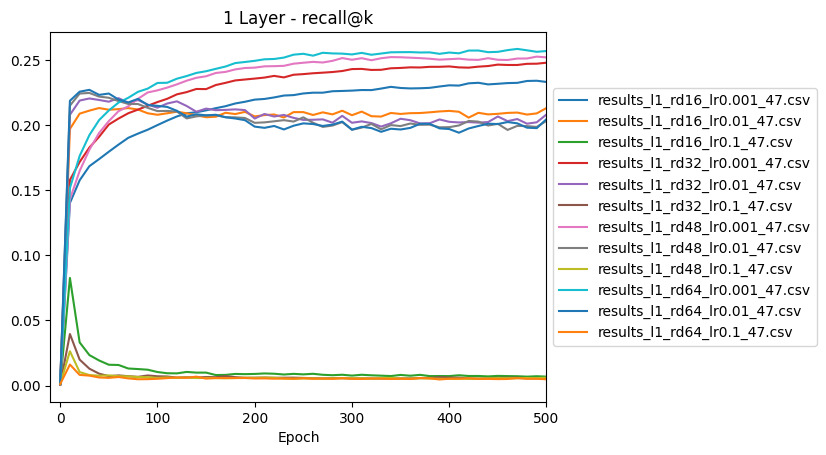

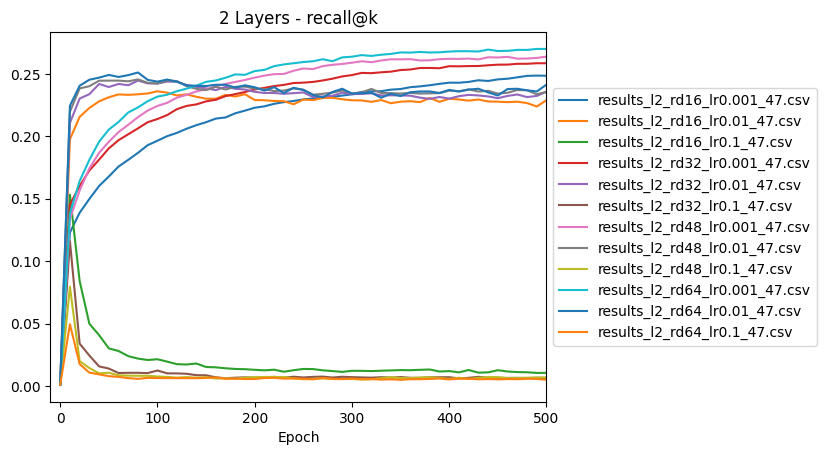

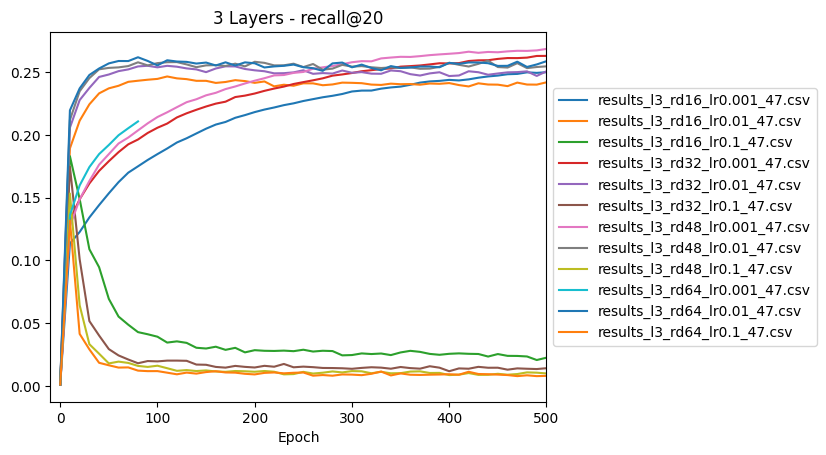

In [12]:
metric = 'recall'
#metric = 'precision'
#metric = 'ndcg'

all_results = os.listdir(os.path.join('..','scripts','LightGCN','results'))
results = [x for x in all_results if '_47' in x]

fig = plt.figure()
results1 = []
for result in results:
    if 'l1' in result:
        results1.append(result)
        resultdf = pd.read_csv(os.path.join('..','scripts','LightGCN','results',result),index_col='Unnamed: 0')
        plt.plot(resultdf[metric])
plt.legend(results1, loc='center left',bbox_to_anchor=(1, 0.5))
plt.title(f'1 Layer - {metric}@k')
plt.xlim((-10,500))
plt.xlabel('Epoch')
plt.show()

fig = plt.figure()
results2 = []
for result in results:
    if 'l2' in result:
        results2.append(result)
        resultdf = pd.read_csv(os.path.join('..','scripts','LightGCN','results',result),index_col='Unnamed: 0')
        plt.plot(resultdf[metric])
plt.legend(results2, loc='center left',bbox_to_anchor=(1, 0.5))
plt.title(f'2 Layers - {metric}@k')
plt.xlim((-10,500))
plt.xlabel('Epoch')
plt.show()

fig = plt.figure()
results3 = []
for result in results:
    if 'l3' in result:
        results3.append(result)
        resultdf = pd.read_csv(os.path.join('..','scripts','LightGCN','results',result),index_col='Unnamed: 0')
        plt.plot(resultdf[metric])
plt.legend(results3, loc='center left',bbox_to_anchor=(1, 0.5))
plt.title(f'3 Layers - {metric}@20')
plt.xlim((-10,500))
plt.xlabel('Epoch')
plt.show()

We see that across the board, the model represented by the light blue line achieves the best outcome. This is the model with `--recdim = 64` and `--lr = 0.001`. We will now compare the score for this model across the layer counts.

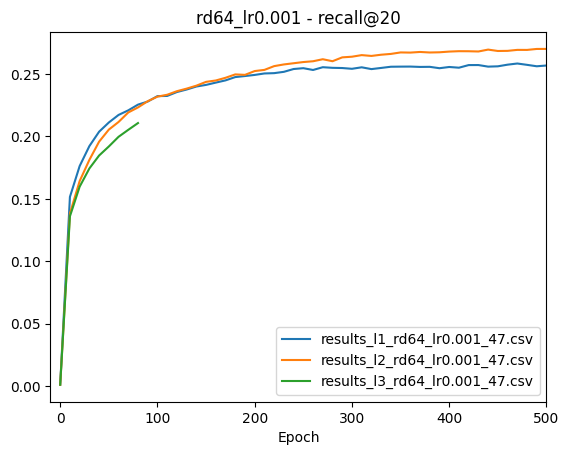

In [13]:
metric = 'recall'
#metric = 'precision'
#metric = 'ndcg'

all_results = os.listdir(os.path.join('..','scripts','LightGCN','results'))
results = [x for x in all_results if '_47' in x]

fig = plt.figure()
results1 = []
for result in results:
    if 'rd64_lr0.001' in result:
        results1.append(result)
        resultdf = pd.read_csv(os.path.join('..','scripts','LightGCN','results',result),index_col='Unnamed: 0')
        plt.plot(resultdf[metric])
plt.legend(results1,loc='lower right')
plt.title(f'rd64_lr0.001 - {metric}@20')
plt.xlim((-10,500))
plt.xlabel('Epoch')
plt.show()

We see that in the long run, the model with 3 layers manages to achieve the greatest recall, and whilst it is not shown above it actually achieves the best results in all three metrics. As such the model we will use for making further predictions will be this one, with 3 layers, 64 features for each embedding, and a learning rate of 0.001.

---

## 7: Running the Final Model

We will now run the final model as decided on in the previous section. We will run it for 1000 epochs to ensure it is fully trained.

In [17]:
# Runs in about 17 mins
LightGCN(lr = 0.001, layer = 3, recdim = 64, epochs = 1000, verbose = False)

Verbose = False
>>SEED: 47
Device used is cuda.
Cpp extension not loaded
loading [last fm 2]
LastFm2 Sparsity : 0.00235706955576828
use NORMAL distribution initilizer
lgn is already to go(dropout:0)
load and save to C:\Users\Sheri\Documents\GitHub\dst-assessment-2\scripts\code\checkpoints\lgn-lastfm2-3-64-47.pth.tar
[TEST]
{'precision': array([0.00026567]), 'recall': array([0.00053135]), 'ndcg': array([0.00040668])}
EPOCH[100/1000] loss0.037-|Sample:0.67|[TEST]
{'precision': array([0.10977683]), 'recall': array([0.22285605]), 'ndcg': array([0.22166219])}
EPOCH[200/1000] loss0.018-|Sample:0.82|[TEST]
{'precision': array([0.12191817]), 'recall': array([0.24783454]), 'ndcg': array([0.2491156])}
EPOCH[300/1000] loss0.014-|Sample:0.82|[TEST]
{'precision': array([0.12938363]), 'recall': array([0.26276884]), 'ndcg': array([0.26270338])}
EPOCH[400/1000] loss0.011-|Sample:0.68|[TEST]
{'precision': array([0.13265143]), 'recall': array([0.26936263]), 'ndcg': array([0.26912709])}
EPOCH[500/1000] l

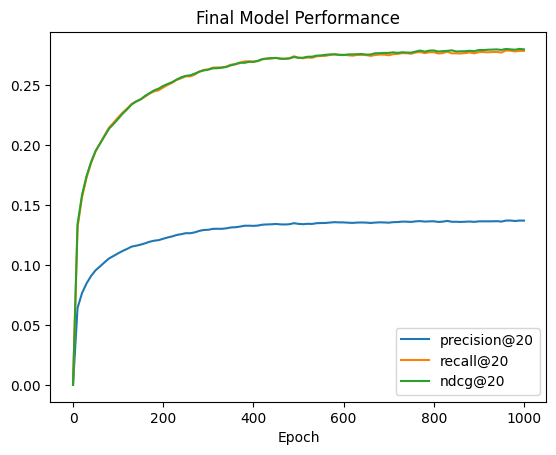

In [18]:
finalresults = pd.read_csv(os.path.join('..','scripts','LightGCN','results','results_l3_rd64_lr0.001_47.csv'), index_col='Unnamed: 0')

plt.figure()
plt.plot(finalresults.index, finalresults['precision'])
plt.plot(finalresults.index, finalresults['recall'])
plt.plot(finalresults.index, finalresults['ndcg'])
plt.title('Final Model Performance')
plt.xlabel('Epoch')
plt.legend(['precision@20','recall@20','ndcg@20'])
plt.show()

---

## 8: Getting Recommendations

In order to use our trained model to make predictions, we can load the checkpoint of the model that is created after training. We can then input a user and some artists to see how the model predicts the user will like those artists. Or we can just input a user and get the top recommendations for them.

In [19]:
## Model needs to be run atleast once so that the scripts can be called like this.
## Run the next two lines if a full run has not been previously done. Should take 10 seconds at most.
# LightGCN(epochs=1,seed=99,verbose=False)
# os.remove(os.path.join('..','scripts','LightGCN','results','results_l3_rd64_lr0.001_99.csv'))

Recmodel = register.MODELS[world.model_name](world.config, dataset).to('cuda')
checkpoint = torch.load('../scripts/code/checkpoints/lgn-lastfm2-3-64-47.pth.tar')
Recmodel.load_state_dict(checkpoint)

use NORMAL distribution initilizer
lgn is already to go(dropout:0)


<All keys matched successfully>

In [20]:
def recommend_top_k(model, user_id, artist_ids, top_k=10, verbose = False):
    """Gets the top k artist recommendations for a given user."""
    GPU = torch.cuda.is_available()
    device2 = torch.device('cuda' if GPU else 'cpu')
    if verbose:
        print(f'Device used is {device2}.')
    user_tensor = torch.tensor([user_id]).to(device2)
    recommendations = []
    artist_tensor = torch.tensor(artist_ids).to(device2)
    recommendation_scores = model(user_tensor, artist_tensor)
    recommendations = [(artist_id, score.item()) for artist_id, score in zip(artist_ids, recommendation_scores)]
    recommendations.sort(key=lambda x: x[1], reverse=True)
    top_recommendations = recommendations[:top_k]
    return top_recommendations

def test_user_predictions(model, userID : int, verbose = False):
    """Tests how the model recommends the artists in the user's test data.""" 
    GPU = torch.cuda.is_available()
    device2 = torch.device('cuda' if GPU else 'cpu')
    if verbose:
        print(f'Device used is {device2}.')
    user_id = userID
    user_tensor = torch.tensor([user_id]).to(device2)
    user_artist_test_list = gf.get_artists(user_id, user_artists_test)
    user_artist_test_list.sort()
    recommendations = []
    for artist_id in user_artist_test_list:
        artist_tensor = torch.tensor([artist_id]).to(device2)
        recommendation_score = model(user_tensor,artist_tensor)
        recommendations.append([artist_id,recommendation_score.item()])
    return recommendations

In [21]:
user_id = 4 
artist_ids = list(artists['id'].unique())
top_k = 10
top_items = recommend_top_k(Recmodel, user_id, artist_ids, top_k)
test_items = test_user_predictions(Recmodel, user_id)

print(f'User {user_id} test artist recommendations:')
for item in test_items:
    print(f"- User {user_id} is recommended artist '{gf.get_artist_name(item[0],artists)}' with score: {item[1]}.")

print(f'\nUser {user_id} top {top_k} recommendations:')
for item in top_items:
    print(f"- User {user_id} is recommended artist '{gf.get_artist_name(item[0],artists)}' with score: {item[1]}.")

User 4 test artist recommendations:
- User 4 is recommended artist 'Duran Duran' with score: 5.978760719299316.
- User 4 is recommended artist 'Air' with score: 4.810736656188965.
- User 4 is recommended artist 'Coldplay' with score: 6.649209976196289.
- User 4 is recommended artist 'Moby' with score: 5.8190083503723145.
- User 4 is recommended artist 'VAST' with score: 5.480764389038086.
- User 4 is recommended artist 'Enrique Iglesias' with score: 6.876409530639648.
- User 4 is recommended artist 'Scissor Sisters' with score: -0.2590234577655792.
- User 4 is recommended artist 'דניאל סלומון' with score: 1.3090952634811401.
- User 4 is recommended artist 'Paradise Lost' with score: 7.851715087890625.
- User 4 is recommended artist 'James Blunt' with score: 1.4431679248809814.

User 4 top 10 recommendations:
- User 4 is recommended artist 'De/Vision' with score: 13.273152351379395.
- User 4 is recommended artist 'Queens of the Stone Age' with score: 11.957819938659668.
- User 4 is reco

We see that for this user, their test artists are almost all recommended positively, and we are also able to get 10 more artists that the model recommends to them. However for other users the model is not as confident.

In [22]:
user_id = 2
artist_ids = list(artists['id'].unique())
top_k = 10
top_items = recommend_top_k(Recmodel, user_id, artist_ids, top_k)
test_items = test_user_predictions(Recmodel, user_id)

print(f'User {user_id} test artist recommendations:')
for item in test_items:
    print(f"- User {user_id} is recommended artist '{gf.get_artist_name(item[0],artists)}' with score: {item[1]:.4f}.")

print(f'\nUser {user_id} top {top_k} recommendations:')
for item in top_items:
    print(f"- User {user_id} is recommended artist '{gf.get_artist_name(item[0],artists)}' with score: {item[1]:.4f}.")

User 2 test artist recommendations:
- User 2 is recommended artist 'Kylie Minogue' with score: -6.3738.
- User 2 is recommended artist 'Daft Punk' with score: 2.7453.
- User 2 is recommended artist 'New Order' with score: 3.8837.
- User 2 is recommended artist 'Prefab Sprout' with score: -3.0230.
- User 2 is recommended artist 'The Adventures' with score: 3.2448.
- User 2 is recommended artist 'Spandau Ballet' with score: -5.2864.
- User 2 is recommended artist 'Vitamin Z' with score: 0.8008.
- User 2 is recommended artist 'Duffy' with score: -6.0018.
- User 2 is recommended artist 'Japan' with score: -8.6472.
- User 2 is recommended artist 'INXS' with score: -5.6387.

User 2 top 10 recommendations:
- User 2 is recommended artist 'Worm Is Green' with score: 11.9784.
- User 2 is recommended artist 'Deru' with score: 11.5157.
- User 2 is recommended artist 'billy gomberg + offthesky' with score: 11.1967.
- User 2 is recommended artist 'ABC' with score: 11.0828.
- User 2 is recommended ar

This user has the majority of their test artists negatively recommended, and for those that are positive the value is small. The model is still able to confidently recommend new artists however, and so is still useful. If we want to check the see if the recommended artists are similar, we can use the last.fm API to get the top tags for each artist and compare them.

In [23]:
# Read API from locally saved text file. This is good practice as you shouldn't publicly upload API keys.
# If an API key is required, a last.fm account is required, then visit here: https://www.last.fm/api/authentication.
# Then edit the file_path below to read the API key from the correct place.
file_path = os.path.join('..', 'SheridanH', 'api-key.txt')
with open(file_path, 'r') as file:
    api_key = file.readline().strip()

def get_artist_tags(api_key, artistID):
    artist_name = gf.get_artist_name(artistID, artists)
    if ' + ' in artist_name:
        artist_name = artist_name.partition(' + ')[0]
    elif ' & ' in artist_name:
        artist_name = artist_name.partition(' & ')[0]
    url = f'https://ws.audioscrobbler.com/2.0/?method=artist.gettoptags&artist={artist_name}&api_key={api_key}&format=json'
    response = requests.get(url)
    data = response.json()
    tags = []
    for i in range(len(data['toptags']['tag'])):
        tags.append(data['toptags']['tag'][i]['name'])
    return artist_name, tags

for artistID in [x[0] for x in top_items]:
    name, tags = get_artist_tags(api_key, artistID)
    print(f"Artist '{name}' has tags:\n {tags}")

Artist 'Worm Is Green' has tags:
 ['icelandic', 'electronic', 'ambient', 'idm', 'electronica', 'trip-hop', 'downtempo', 'post-rock', 'seen live', 'indie', 'female vocalists', 'experimental', 'iceland', 'indie-electronic', 'chillout', 'glitch', 'indietronica', 'scandinavian', 'post rock', 'dreampop', 'electropop', 'trip hop', 'dream pop', 'Worm is Green', 'electro', 'Island', 'dreamtronica']
Artist 'Deru' has tags:
 ['idm', 'ambient', 'electronic', 'glitch', 'electronica', 'experimental', 'downtempo', 'abstract', 'american', 'chillout', 'minimal', 'm3rck', 'avantgarde', 'noise', 'trip-hop', 'USA', 'Ghostly International', 'neo ouija', 'seen live', 'instrumental', 'techno', 'night', 'glitch-hop', 'abstract hip-hop', 'us', 'merck', 'All', 'pra', 'delikatessen records', 'mad-hop', 'limpet hiphop']
Artist 'billy gomberg' has tags:
 ['ambient', 'Avant-Garde', 'electroacoustic', 'minimal', 'experimental', 'ilse', 'electronic', 'glitch', 'drone', 'eai', 'improv', 'sound art', 'avant archive', 

We see that for user 2, the recommended artists are fairly similar, with all of them being tagged with `electronic`, and many of them also including `ambient` and other similar tags. This suggests that the model is in fact correctly learning relationships between the artist nodes and building patterns based on user listening data.

---

## 9: Investigating the Computational Performance of the Model

Throughout this document we have already considered the time required to run the model at a few different occasions. We will look at it in more depth here, only considering the training time since the 'bootup' time taken for the model to load everything will be static across different parameters.

In [24]:
for epoch in [1,5,25,125,625]:
    output = io.StringIO()
    with contextlib.redirect_stdout(output):
        LightGCN(seed = 101, epochs = epoch, verbose=False)
    captured_output = output.getvalue()
    print(f"Training Time for {epoch} epochs: {float(captured_output.partition('Training time: ')[2]):.4f} seconds")

Training Time for 1 epochs: 3.0446 seconds
Training Time for 5 epochs: 6.9487 seconds
Training Time for 25 epochs: 27.2036 seconds
Training Time for 125 epochs: 131.9016 seconds
Training Time for 625 epochs: 652.8090 seconds


We see that the time complexity for the training of the model scales linearly with the number of epochs, with a 5 times increase in epochs leading to a roughly 5 times increase in training time. We can also see how much GPU memory the model uses using some built in torch functions.

In [25]:
torch.cuda.reset_peak_memory_stats(device=None)

before = torch.cuda.max_memory_allocated(device=None)
output = io.StringIO()
with contextlib.redirect_stdout(output):
    LightGCN(seed=101,epochs=1,verbose=False,recdim=64)
after = torch.cuda.max_memory_allocated(device=None)

usageB = after - before
usageMB = usageB / (1024**2)

print(f'Model used {usageMB:.2f}MB of GPU memory.')

Model used 48.57MB of GPU memory.


In [26]:
torch.cuda.reset_peak_memory_stats(device=None)

before = torch.cuda.max_memory_allocated(device=None)
output = io.StringIO()
with contextlib.redirect_stdout(output):
    recommend_top_k(Recmodel,2,artist_ids)
after = torch.cuda.max_memory_allocated(device=None)

usageB = after - before
usageMB = usageB / (1024**2)
print(f'Model used {usageMB:.2f}MB of GPU memory.')

Model used 40.85MB of GPU memory.


The model uses around 40MB of memory to both train the model and then also make predictions, (in our tests this varies from around 40 to 80). This does not change with most parameters, as in most cases the actual data is not effected by the parameters, but rather just the methods used. However, the memory usage does seem to scale with the number of embedding features (`--recdim`).

In [27]:
for rd in [16,32,64,128,256]:
    torch.cuda.reset_peak_memory_stats(device=None)

    before = torch.cuda.max_memory_allocated(device=None)
    output = io.StringIO()
    with contextlib.redirect_stdout(output):
        LightGCN(seed=101,epochs=1,verbose=False,recdim=rd)
    after = torch.cuda.max_memory_allocated(device=None)

    usageB = after - before
    usageMB = usageB / (1024**2)

    print(f'Model used {usageMB:.2f}MB of GPU memory with recdim = {rd}.')

Model used 5.63MB of GPU memory with recdim = 16.
Model used 34.42MB of GPU memory with recdim = 32.
Model used 58.75MB of GPU memory with recdim = 64.
Model used 111.29MB of GPU memory with recdim = 128.
Model used 212.13MB of GPU memory with recdim = 256.


Except for when `--recdim = 16`, the memory usage seems to scale linearly. This is interesting because it shows us that while the model may perform better with more embedding features, the cost of that is a higher memory usage, and whilst this is not a big deal on this scale, were this to be applied to big data a decision would have to be made on how much more memory usage is worth it for better results.

---

## 10: Conclusion

---

# 11: References

[1] Papers With Code: Graph Models - https://paperswithcode.com/methods/category/graph-models

[2] Towards Data Science: Graph Convolutional Networks - https://towardsdatascience.com/graph-convolutional-networks-introduction-to-gnns-24b3f60d6c95

[3] Xiangnan He, et al. 2020. LightGCN: Simplifying and Powering Graph Convolution Network for Recommendation - https://arxiv.org/abs/2002.02126

[4] Guyse1234 Github Repository: LightGCN-PyTorch - https://github.com/gusye1234/LightGCN-PyTorch

[5] NVIDIA: CUDA Toolkit - https://developer.nvidia.com/cuda-toolkit

[6] Towards Data Science: Why Deep Learning Models Run Faster on GPUs: A Brief Introduction to CUDA Programming - https://towardsdatascience.com/why-deep-learning-models-run-faster-on-gpus-a-brief-introduction-to-cuda-programming-035272906d66